In [1]:
import numpy as np
import scipy
import scipy.io as io

from trefide.solvers.lagrangian import lpdas
from trefide.solvers.constrained import cpdas
from timeit import timeit

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prepare Data

In [2]:
import trefide.utils.preprocess as preprocess

In [3]:
# Load Data
stim = scipy.io.loadmat("./data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("./data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [4]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [5]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

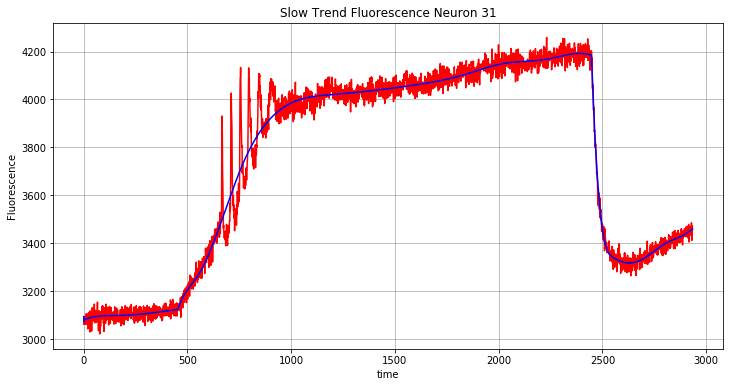

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Explore Thresholding & Reweighting

In [7]:
import trefide.utils.noise as noise
import numpy.random

In [9]:
#idx = np.random.randint(0, N)
raw = signals[idx,:]
#jdx = np.random.randint(0, N)
#kdx = np.random.randint(0, N)
#raw = np.flip(signals[idx,:], axis=0) + 2 * signals[jdx,:] + signals[kdx,:]
#raw = np.append(raw, np.flip(raw, axis=0)*-1)
#raw = raw + 1000*np.cos(np.arange(len(raw))*.00051)
#raw = raw + np.arange(len(raw))*.5

In [49]:
noise_factor = 6
raw_noise_std = noise.estimate_noise([raw], summarize="mean")[0]
signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(raw)) + raw
delta = noise.estimate_noise([signal])[0]**2

In [63]:
x_hat, z_hat, lam, _ = cpdas(signal, delta)
mad = np.median(np.abs(x_hat) - np.median(x_hat))

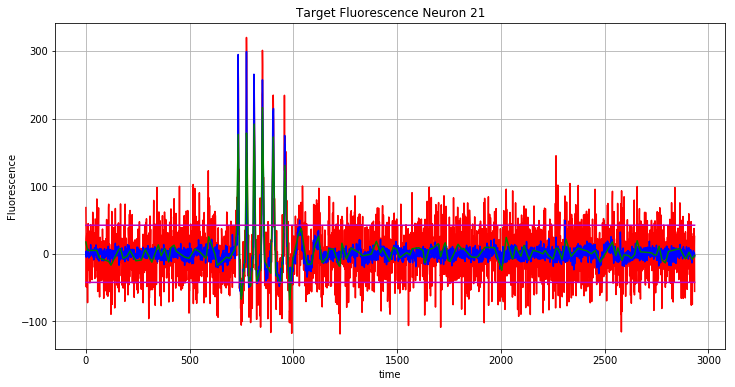

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.array(x_hat), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [65]:
# upweight spikes
wi = np.ones(len(signal))
wi[700:1100] = .1
delta_w = np.mean(np.power(wi, -1))

In [66]:
x_hat, z_hat, lam, _ = cpdas(signal, delta, wi=wi, lambda_=lam, z_hat=z_hat)
mad = np.median(np.abs(x_hat) - np.median(x_hat))

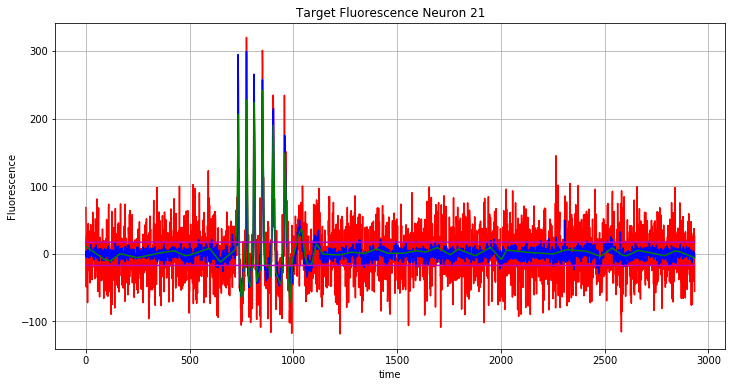

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.array(x_hat), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [62]:
rdx = [0,600,900, len(signal)]
ff = [1,1,1]
# run constrained in each region
x = []
l = []
z_init = z_hat.copy()
for r in range(len(rdx)-1):
    x_hat_r, z_hat_r, lam_r, _ = cpdas(signal[rdx[r]:rdx[r+1]],
                                       delta*ff[r])
    x.append(x_hat_r)
    l.append(lam_r)

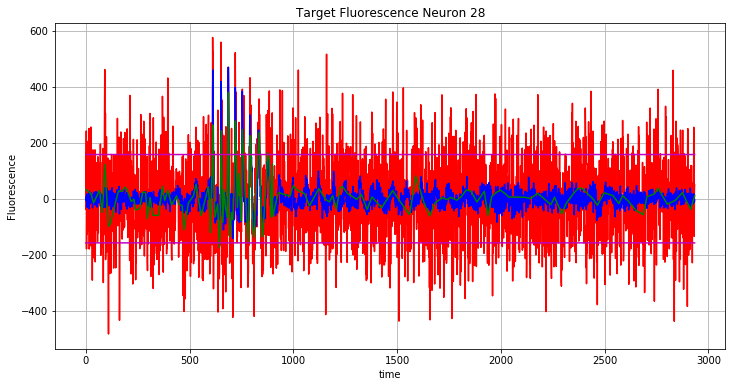

In [365]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.concatenate(x), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [366]:
l

[860.5054867780401, 431.94119171766505, 2099.1689165662997]

In [367]:
rlam = np.repeat(l,[rdx[1], rdx[2] - rdx[1], rdx[3]-rdx[2]])

In [368]:
wi = rlam/lam

In [369]:
wi[rdx[1]:rdx[2]] /=2

In [370]:
x_hat, z_hat, _ = lpdas(signal, lam, z_hat=z_init, wi=wi, verbose=1)

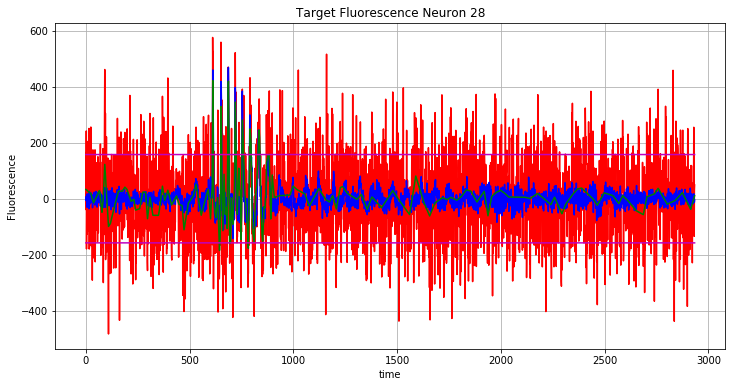

In [371]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.asarray(x_hat), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [70]:
# threshold to identify spikes
mad = np.median(np.abs(x_hat) - np.median(x_hat))
thresh = 9 * mad
# upweight spikes
wi = np.ones(len(signal))
#wi[700:1100] = .01
wi[np.abs(np.array(x_hat)) >= thresh] /= 10
wi[np.abs(np.array(x_hat)) < thresh] *= 2
# refit
#x_hat, z_hat, _ = lpdas(signal, lam, z_hat=z_hat, wi=wi, verbose=1)
x_hat, z_hat, _, _ = cpdas(signal, delta, z_hat=z_hat, wi=wi, verbose=1)

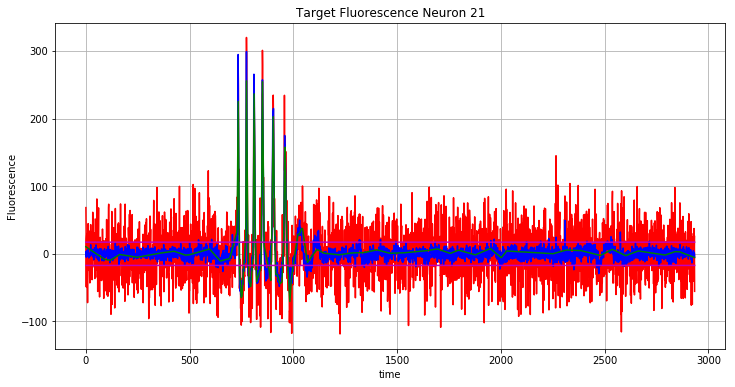

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(len(raw)), signal, 'r')
ax.plot(np.arange(len(raw)), raw, 'b')
ax.plot(np.arange(len(raw)), np.array(x_hat), 'g')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*9*mad, 'm')
ax.plot(np.arange(len(raw)), np.ones(len(raw))*-9*mad, 'm')
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

1. Run with loosened noise levels and threshold to detect active regions
2. Run again with upweighted spiking regions (target noise level) (still targeting same lambda)
3. Threshold results and further uweight just the spikes, downweight the rest slightly
4. Final fit.